## Petrophysical properties inversion from seismic data

In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
from random import randint
from wiggle.wiggle import wiggle
from matplotlib.pyplot import figure
import math
import tensorflow as tf

In [2]:
# Checking the devices available for use in AWS
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 175845089863631524
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9799266853168430338
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17767983709533994645
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 145555456
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10613034148283381434
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [3]:
# Loading the Vp, Vs and Density data

dataframe = sio.loadmat('../../../Data_generation_base_case/Train_DataSyn1_time_clip.mat')
Vp = dataframe['VpMat']
Vp = np.reshape(Vp, (Vp.shape[0]*Vp.shape[1], Vp.shape[2]))
Vs = dataframe['VsMat']
Vs = np.reshape(Vs, (Vs.shape[0]*Vs.shape[1], Vs.shape[2]))
RHOB = dataframe['RHOBMat']
RHOB = np.reshape(RHOB, (RHOB.shape[0]*RHOB.shape[1], RHOB.shape[2]))

depth = dataframe['depthVec']

# Loading facies, porosity, vclay and water saturation data 
dataframe_facies = sio.loadmat('../../../Data_generation_base_case/Train_FaciesMat.mat')
facies = dataframe_facies['zFaciesMat']
facies = np.reshape(facies, (facies.shape[0]*facies.shape[1], facies.shape[2]))

dataframe_porosity = sio.loadmat('../../../Data_generation_base_case/Train_PhiMat.mat')
porosity = dataframe_porosity['zPhiMat']
porosity = np.reshape(porosity, (porosity.shape[0]*porosity.shape[1], porosity.shape[2]))

dataframe_vclay = sio.loadmat('../../../Data_generation_base_case/Train_ClayMat.mat')
vclay = dataframe_vclay['zClayMat']
vclay = np.reshape(vclay, (vclay.shape[0]*vclay.shape[1], vclay.shape[2]))

dataframe_Sw = sio.loadmat('../../../Data_generation_base_case/Train_SwMat.mat')
Sw = dataframe_Sw['zSwMat']
Sw = np.reshape(Sw, (Sw.shape[0]*Sw.shape[1], Sw.shape[2]))


Text(0.5,0,'Vp/Vs [ratio]')

<Figure size 720x720 with 0 Axes>

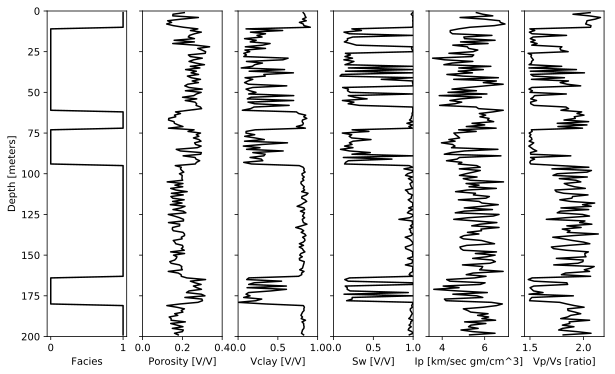

In [4]:
# Plot of loaded data

plt.figure(figsize=(10,10))

sample_number = 12
f, axarr = plt.subplots(1, 6, sharey = True, figsize=(10,6))

axarr[0].plot(facies[sample_number, :], depth, color = "black")
axarr[0].set_xlabel("Facies")
axarr[0].set_ylabel("Depth [meters]")
axarr[0].set_ylim([0,200])
axarr[0].invert_yaxis()

axarr[1].plot(porosity[sample_number, :], depth, color = "black")
axarr[1].set_xlabel("Porosity [V/V]")
axarr[1].set_xlim(0,0.4)

axarr[2].plot(vclay[sample_number, :], depth, color = "black")
axarr[2].set_xlabel("Vclay [V/V]")
axarr[2].set_xlim(0,1)

axarr[3].plot(Sw[sample_number, :], depth, color = "black")
axarr[3].set_xlabel("Sw [V/V]")
axarr[3].set_xlim(0,1)

axarr[4].plot(Vp[sample_number, :]*RHOB[sample_number, :], depth, color = "black")
axarr[4].set_xlabel("Ip [km/sec gm/cm^3]")
# plt.xlim(0,1)

axarr[5].plot(Vp[sample_number, :]/Vs[sample_number, :], depth, color = "black")
axarr[5].set_xlabel("Vp/Vs [ratio]")
# plt.xlim(0,1)

# axarr[6].plot(RHOB[sample_number, :], depth, color = "black")
# axarr[6].set_xlabel("RHOB")
# # plt.xlim(0,1)

# axarr[7].plot(Vp[sample_number, :]*RHOB[sample_number, :], depth)
# axarr[7].set_xlabel("Ip")

In [5]:
# AVO and source parameters 
src_len=np.int(60)
freq=40
dt=7e-4
# ntheta=46
thetaStart=0
thetaEnd=30
thetaInc=5
theta=np.arange(thetaStart,thetaEnd+thetaInc,thetaInc)
ntheta=theta.size
# nt=201
# ncdp=1111
angle=np.reshape(theta,[1,ntheta])
# theta=np.arange(0,ntheta,1)
print('angle:', angle.shape)
print('angle:', angle)

angle: (1, 7)
angle: [[ 0  5 10 15 20 25 30]]


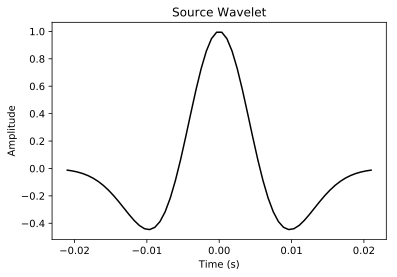

In [6]:
# Generate the seismic wavelet
def ricker(f,n,dt,t0):

    T = dt*(np.floor(n/2));
    t = np.linspace(-T,T,n)
    tau = t-t0;
    pi=np.pi
    s = (1-2*tau*tau*f**2*pi**2)*np.exp(-tau**2*pi**2*f**2);
    rw = s;

    return rw,t
src,tsrc=ricker(freq,src_len,dt,0)
plt.plot(tsrc,src, '-k')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Source Wavelet")
plt.show()

In [7]:
# Full Zoeppritz using tensorflow

def gather(input1,tftheta,tfsrc):
    print('input1:',input1)
    vp = tf.expand_dims(input1[:,:,0],2)
    vs = tf.expand_dims(input1[:,:,1],2)
    rho = tf.expand_dims(input1[:,:,2],2)
    vp=tf.check_numerics(vp,"Nan at vp start")
    vs=tf.check_numerics(vs,"Nan at vp start")
    rho=tf.check_numerics(rho,"Nan at vp start")
    

    nref= tf.shape(input1)[1]#vp.get_shape()[1]#.as_list()[1]
    bs=tf.shape(input1)[0]
    ntheta=tf.shape(tftheta)[1]
    #nt=tf.shape(input1)[1]
    
    tfzero=tf.zeros([bs,1,ntheta], dtype=tf.float32)
    
    tfangle = tf.expand_dims(tf.convert_to_tensor(tftheta, 
                                                  dtype=tf.float32),0)
    tfangle=tf.tile(tfangle,[bs,nref-1,1])

  
    vp1=tf.tile(vp[:,0:nref-1],[1, 1, ntheta])
    vs1=tf.tile(vs[:,0:nref-1],[1, 1, ntheta])
    d1=tf.tile(rho[:,0:nref-1],[1, 1, ntheta])

    vp2=tf.tile(vp[:,1:nref],[1, 1, ntheta])
    vs2=tf.tile(vs[:,1:nref],[1, 1, ntheta])
    d2=tf.tile(rho[:,1:nref],[1, 1, ntheta])
    
    
    vpj1=tf.complex(vp1,tf.zeros_like(vp1))
    vsj1=tf.complex(vs1,tf.zeros_like(vs1))
    dj1=tf.complex(d1,tf.zeros_like(d1))

    vpj2=tf.complex(vp2,tf.zeros_like(vp2))
    vsj2=tf.complex(vs2,tf.zeros_like(vs2))
    dj2=tf.complex(d2,tf.zeros_like(d2))
    
    
    t=tf.scalar_mul(np.pi/180,tfangle)    
    p=tf.divide(tf.sin(t),vp1)
    ct=tf.cos(t)
    
    sint=tf.complex(tf.sin(t),tf.zeros_like(t))
    
    # FULL ZOEPPRITZ
    ct2=tf.real(tf.sqrt(np.subtract(1+0j,tf.multiply(tf.square(sint)
                , tf.divide(tf.square(vpj2),tf.square(vpj1))))))
    
    cj1=tf.real(tf.sqrt(np.subtract(1+0j,tf.multiply(tf.square(sint)
                , tf.divide(tf.square(vsj1),tf.square(vpj1))))))
    
    cj2=tf.real(tf.sqrt(np.subtract(1+0j,tf.multiply(tf.square(sint)
                , tf.divide(tf.square(vsj2),tf.square(vpj1))))))
    
    a=tf.subtract(
            tf.multiply(d2, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs2), tf.square(p))))),
            tf.multiply(d1, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs1), tf.square(p)))))
            )
    
    b=tf.add(
            tf.multiply(d2, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs2), tf.square(p))))),
            tf.multiply(d1,tf.scalar_mul(2.0,tf.multiply(tf.square(vs1), tf.square(p))))
            )
    c=tf.add(
            tf.multiply(d1, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs1), tf.square(p))))),
            tf.multiply(d2,tf.scalar_mul(2.0,tf.multiply(tf.square(vs2), tf.square(p))))
            )
    
    d=tf.scalar_mul(2.0, 
            tf.subtract(
                    tf.multiply(d2,tf.square(vs2)),
                    tf.multiply(d1,tf.square(vs1)))
            )
            
    E=tf.add(
            tf.multiply(b,tf.divide(ct,vp1)),
            tf.multiply(c,tf.divide(ct2,vp2))
            )
    F=tf.add(
            tf.multiply(b,tf.divide(cj1,vs1)),
            tf.multiply(c,tf.divide(cj2,vs2))
            )
    G=tf.subtract(a,
                  tf.divide(
                          tf.multiply(d,tf.multiply(ct,cj2)),
                          tf.multiply(vp1,vs2))
                  )
    H=tf.subtract(a,
                  tf.divide(
                          tf.multiply(d,tf.multiply(ct2,cj1)),
                          tf.multiply(vp2,vs1))
                  )
    D=tf.add(
            tf.multiply(E,F),
            tf.multiply(G,tf.multiply(H,tf.square(p)))
            )
    
    Rpp=tf.real(tf.divide(tf.subtract(
            tf.multiply(tf.subtract( tf.multiply(b,tf.divide(ct,vp1)), tf.multiply(c,tf.divide(ct2,vp2))),F),
            tf.multiply( tf.add(a, tf.multiply(d,tf.multiply(ct,tf.divide(cj2,tf.multiply(vp1,vs2))))) ,tf.multiply(H,tf.square(p)))            
            ),D))
    #print('Rpp1:',Rpp)
    Rpp=tf.concat([Rpp,tfzero],1)
    #print('Rpp2:',Rpp)
    # Rpp1=tf.zeros()
    Rpp1=tf.expand_dims(Rpp,axis=3)
    #Rpp1=tf.where(tf.is_nan(Rpp1), tf.zeros_like(Rpp1), Rpp1)
    #print('Rpp11:',Rpp1)
    #print('tfsrc:',tfsrc)
    seis=tf.transpose(tf.nn.conv2d(Rpp1,tfsrc,strides=[1,1,1,1],padding='SAME'),perm=[0,2,1,3])
    #print("seis:",seis)
    seis=tf.reshape(seis,[-1,nt*ntheta])
    #seis=tf.Print(seis,[tf.shape(seis)])

    #print('seis:',seis)
    
    return seis,Rpp

In [8]:
# Convert Vp, Vs and Density logs from depth to time 
time = np.zeros((Vp.shape[0], Vp.shape[1]+1))

for i in range(time.shape[0]):
    depth_diff = np.mean(np.diff(depth.T))
    time[i,0] = 0
    time[i,1:] = 2*np.cumsum(depth_diff/(Vp[i,:]*1e3))

time = time[:,0:-1]
# Interpolate the time values such that all logs have the same dt_log
end_time = (np.max(time))
time_upscaled = np.arange(0, end_time, dt)

Vp_time = np.zeros((Vp.shape[0], time_upscaled.shape[0]))
Vs_time = np.zeros((Vs.shape[0], time_upscaled.shape[0]))
RHOB_time = np.zeros((RHOB.shape[0], time_upscaled.shape[0]))
for i in range(time.shape[0]):
    Vp_time[i,:] = np.interp(time_upscaled, time[i,:], Vp[i,:])
    Vs_time[i,:] = np.interp(time_upscaled, time[i,:], Vs[i,:])
    RHOB_time[i,:] = np.interp(time_upscaled, time[i,:], RHOB[i,:])
    
nt = time_upscaled.shape[0]    

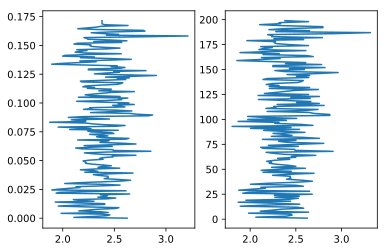

In [9]:
sample_number = 10
plt.subplot(1,2,1)
plt.plot(Vp_time[sample_number,:], time_upscaled)
plt.subplot(1,2,2)
plt.plot(Vp[sample_number,:], depth)


In [ ]:
# Forward modeling results (Seismic gathers)

# Test the forward modeling
bs=Vp_time.shape[0]
input11=np.zeros([bs,nt,3],dtype=np.float32)

input11[0:bs,:,0]=Vp_time[0:bs,:]
input11[0:bs,:,1]=Vs_time[0:bs,:]
input11[0:bs,:,2]=RHOB_time[0:bs,:]
# plt.plot(np.squeeze(input11))
# plt.show()

input111=tf.convert_to_tensor(input11,dtype=tf.float32)
# print("src:",src.shape)


tfsrc=tf.reshape(tf.constant(src,dtype=tf.float32),[src_len,1,1,1])


# print('tfsrc:',tfsrc)
# print('angle:',angle.shape)
tftheta=tf.convert_to_tensor(angle,dtype=tf.float32)
# print('tftheta:',tftheta)
seisgen=gather(input111,tftheta,tfsrc)


sess=tf.Session()
seis11,Rpp11=sess.run(seisgen)

sess.close()

seis=np.transpose(np.reshape(seis11,[-1,ntheta,nt]),[0,2,1])
Rpp=Rpp11#np.reshape(Rpp11,[bs,nt,ntheta])

sample_number = 20
wiggle(np.squeeze(seis[sample_number,:,:]),time_upscaled,theta)
plt.title("Seismogram")
plt.xlabel("$\\theta$")
plt.ylabel("Time (s)")
plt.show()

impedance_time = Vp_time * RHOB_time
impedance_time_sample = impedance_time[sample_number,:]
plt.subplot(1,3,1)
plt.plot((impedance_time_sample - np.min(impedance_time_sample))/(np.max(impedance_time_sample)-np.min(impedance_time_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,2)
seis_sample = np.squeeze(seis[sample_number,:,0])
plt.plot((seis_sample - np.min(seis_sample))/(np.max(seis_sample) - np.min(seis_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,3)
plt.plot(np.squeeze(Rpp[sample_number,:,0]), time_upscaled)
plt.gca().invert_yaxis()

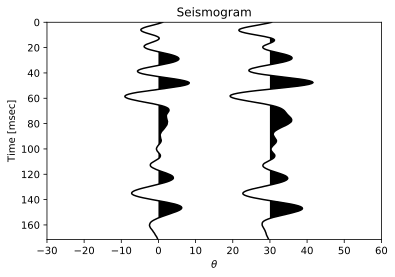

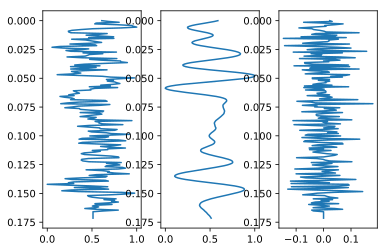

In [10]:
# Load forward modeled seismic data and Rpp
seis = np.load('../../../Data_generation_base_case/seismic_forward_modeled.npy')
Rpp = np.load('../../../Data_generation_base_case/Rpp_forward_modeled.npy')

sample_number = 12
row_idx = np.array([0, 6])
wiggle(np.squeeze(seis[sample_number,:,row_idx]).T,time_upscaled*1e3,theta[row_idx])
plt.title("Seismogram")
plt.xlabel("$\\theta$")
plt.ylabel("Time [msec]")
plt.show()

impedance_time = Vp_time * RHOB_time
impedance_time_sample = impedance_time[sample_number,:]
plt.subplot(1,3,1)
plt.plot((impedance_time_sample - np.min(impedance_time_sample))/(np.max(impedance_time_sample)-np.min(impedance_time_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,2)
seis_sample = np.squeeze(seis[sample_number,:,0])
plt.plot((seis_sample - np.min(seis_sample))/(np.max(seis_sample) - np.min(seis_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,3)
plt.plot(np.squeeze(Rpp[sample_number,:,0]), time_upscaled)
plt.gca().invert_yaxis()

<Figure size 720x1440 with 0 Axes>

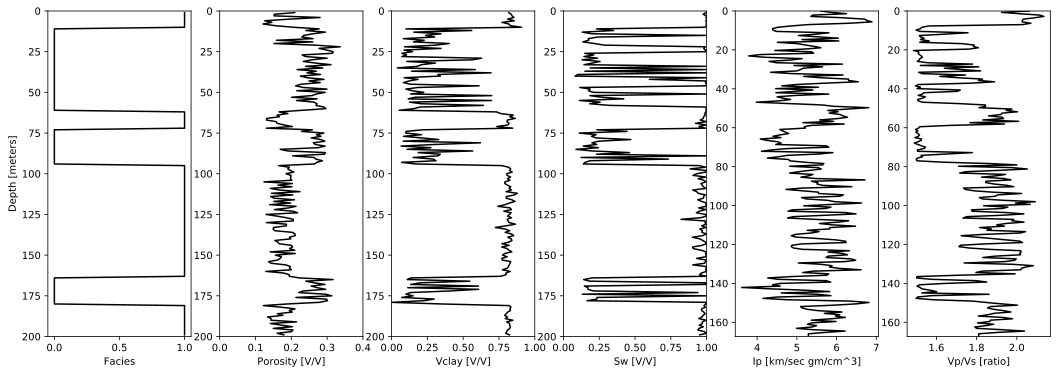

In [11]:
# Plot of loaded data

plt.figure(figsize=(10,20))

sample_number = 12
f, axarr = plt.subplots(1, 6, sharey = False, figsize=(18,6))

axarr[0].plot(facies[sample_number, :], depth, color = "black")
axarr[0].set_xlabel("Facies")
axarr[0].set_ylabel("Depth [meters]")
axarr[0].set_ylim([0,200])
axarr[0].invert_yaxis()

axarr[1].plot(porosity[sample_number, :], depth, color = "black")
axarr[1].set_xlabel("Porosity [V/V]")
axarr[1].set_xlim(0,0.4)
# axarr[1].set_ylabel("Depth [meters]")
axarr[1].set_ylim([0,200])
axarr[1].invert_yaxis()

axarr[2].plot(vclay[sample_number, :], depth, color = "black")
axarr[2].set_xlabel("Vclay [V/V]")
axarr[2].set_xlim(0,1)
# axarr[2].set_ylabel("Depth [meters]")
axarr[2].set_ylim([0,200])
axarr[2].invert_yaxis()


axarr[3].plot(Sw[sample_number, :], depth, color = "black")
axarr[3].set_xlabel("Sw [V/V]")
axarr[3].set_xlim(0,1)
# axarr[3].set_ylabel("Depth [meters]")
axarr[3].set_ylim([0,200])
axarr[3].invert_yaxis()


axarr[4].plot(Vp_time[sample_number, :-6]*RHOB_time[sample_number, :-6], time_upscaled[:-6]*1e3, color = "black")
axarr[4].set_xlabel("Ip [km/sec gm/cm^3]")
# axarr[4].set_ylabel("Time [msec]")
axarr[4].set_ylim([np.min(time_upscaled[:-6])*1e3,np.max(time_upscaled[:-6])*1e3])
axarr[4].invert_yaxis()
# plt.xlim(0,1)

axarr[5].plot(Vp_time[sample_number, :-6]/Vs_time[sample_number, :-6], time_upscaled[:-6]*1e3, color = "black")
axarr[5].set_xlabel("Vp/Vs [ratio]")
# axarr[5].set_ylabel("Time [msec]")
axarr[5].set_ylim([np.min(time_upscaled[:-6])*1e3,np.max(time_upscaled[:-6])*1e3])
axarr[5].invert_yaxis()
# plt.xlim(0,1)

# axarr[6].plot(RHOB[sample_number, :], depth, color = "black")
# axarr[6].set_xlabel("RHOB")
# # plt.xlim(0,1)

# axarr[7].plot(Vp[sample_number, :]*RHOB[sample_number, :], depth)
# axarr[7].set_xlabel("Ip")

In [12]:
# Import keras modules for CNN

from keras import layers, initializers, optimizers
from keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling1D, MaxPooling2D, Dropout, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import LeakyReLU, Reshape
from keras.models import Model, model_from_json, load_model
from keras.preprocessing import image
from keras.utils import layer_utils, normalize
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.utils import np_utils, normalize
from keras.backend import manual_variable_initialization
from keras.callbacks import EarlyStopping, ModelCheckpoint

# from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')

import sklearn.model_selection
import pydot

Using TensorFlow backend.


In [13]:
# Getting the input data (normalized) and output data 

# Reshape seismic gathers into (number of examples, angle, time) and normalize such that seismic traces have positive values
seis_reshaped = np.swapaxes(seis,1,2)
# seis_reshaped_normalized = (seis_reshaped - np.min(seis_reshaped))/(np.max(seis_reshaped)-np.min(seis_reshaped))
# Normalizing each trace individually
seis_test = np.reshape(seis_reshaped, (seis_reshaped.shape[0]*seis_reshaped.shape[1], seis_reshaped.shape[2]))
seis_reshaped_normalized = np.transpose(
    (seis_test.T - np.min(seis_test, axis=1))/(np.max(seis_test, axis=1) - np.min(seis_test, axis=1)))
seis_reshaped_normalized = np.reshape(seis_reshaped_normalized, (seis_reshaped.shape[0], seis_reshaped.shape[1], seis_reshaped.shape[2]))


# Selecting near(0 degree) and far (30 degree) angle traces from the full seismic gathers
row_idx = np.array([0, 6])
angle_seis_reshaped_normalized = seis_reshaped_normalized[:,row_idx,:]

# Concatenate Porosity, Vclay, Sw 
num_examples = porosity.shape[0]
ndepth = porosity.shape[1]

# Normalize porosity
porosity_norm = (porosity - np.min(porosity))/(np.max(porosity) - np.min(porosity))

# petromodel = np.concatenate((porosity_norm,vclay,Sw), axis=1)
# petromodel = petromodel.reshape((num_examples, 3, ndepth))
petromodel = np.concatenate((porosity_norm,vclay), axis=1)
petromodel = petromodel.reshape((num_examples, 2, ndepth))


# Split data into train and test set - petro model
# X_train_petro, X_test_petro, Y_train_petro, Y_test_petro = sklearn.model_selection.train_test_split(seis_reshaped_normalized, 
#                                                                             petromodel, test_size=0.2, random_state=1)
X_train_petro, X_test_petro, Y_train_petro_norm, Y_test_petro_norm = sklearn.model_selection.train_test_split(angle_seis_reshaped_normalized, 
                                                                            petromodel, test_size=0.2, random_state=1)

# Add 4th dimension of number of channels=1 to the input data
X_train_petro = np.expand_dims(X_train_petro, axis=3)
X_test_petro = np.expand_dims(X_test_petro, axis=3)

print ("number of training examples petromodel = " + str(X_train_petro.shape[0]))
# print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples petromodel = " + str(X_test_petro.shape[0]))
print ("X_train_petromodel shape: " + str(X_train_petro.shape))
print ("Y_train_petromodel shape: " + str(Y_train_petro_norm.shape))
# print ("X_val shape: " + str(X_val.shape))
# print ("Y_val shape: " + str(Y_val.shape))
print ("X_test_petromodel shape: " + str(X_test_petro.shape))
print ("Y_test_petromodel shape: " + str(Y_test_petro_norm.shape))

number of training examples petromodel = 2000
number of test examples petromodel = 500
X_train_petromodel shape: (2000, 2, 246, 1)
Y_train_petromodel shape: (2000, 2, 199)
X_test_petromodel shape: (500, 2, 246, 1)
Y_test_petromodel shape: (500, 2, 199)


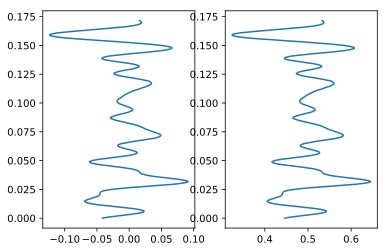

In [14]:
seis_reshaped_normalized = (seis_reshaped - np.min(seis_reshaped))/(np.max(seis_reshaped)-np.min(seis_reshaped))

plt.subplot(1,2,1)
plt.plot(np.squeeze(seis_reshaped[2,1,:]),time_upscaled)
plt.subplot(1,2,2)
plt.plot(np.squeeze(seis_reshaped_normalized[2,1,:]),time_upscaled)

In [15]:
# Building neural network for petrophysical properties prediction in Keras 
given_seed = 3 # For repeatibility


def petronet(input_shape):
    """
    Implementation of the PetroNet.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    

    # Define the input placeholder as a tensor with shape input_shape. Input = input angle gather 
    X_input = Input(input_shape)

    X = X_input

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(64, (2, 7), strides=(1, 2), name='conv0', padding='same',
               kernel_initializer=initializers.glorot_uniform(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn0')(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.3, name='drop_conv0')(X)
    # MAXPOOL
#     X = MaxPooling2D((1, 2), strides=(1,2),name='max_pool0')(X)
    
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (2, 15), strides=(1, 2), name='conv1',padding='same',
               kernel_initializer=initializers.glorot_uniform(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn1')(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.3, name='drop_conv1')(X)
    # MAXPOOL
#     X = MaxPooling2D((1, 2), strides=(1,2),name='max_pool1')(X)
    
    
#     # CONV -> BN -> RELU Block applied to X
    X = Conv2D(16, (1, 30), strides=(1, 2), name='conv2',padding='same',
               kernel_initializer=initializers.glorot_uniform(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn2')(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.3, name='drop_conv2')(X)
#     # MAXPOOL
#     X = MaxPooling2D((1, 2), strides=(1,2),name='max_pool2')(X)
    
    
#     # CONV -> BN -> RELU Block applied to X
    X = Conv2D(8, (1, 60), strides=(1, 2), name='conv3',padding='same',
               kernel_initializer=initializers.glorot_uniform(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn3')(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.3, name='drop_conv3')(X)
#     # MAXPOOL
#     X = MaxPooling2D((1, 2), strides=(1,2),name='max_pool3')(X)
    

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    
    # Considering Sw first dimension is 3, without first dimension is 2
    X = Dense(199*2, name='fc1', 
             kernel_initializer=initializers.glorot_uniform(seed=given_seed), bias_initializer='zeros')(X)
    X = Activation('relu')(X)
#     X = LeakyReLU(0.3)(X)
    X = Reshape((2, 199))(X)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=X, name='PetroModel')

    return model
    ### END CODE HERE ###

In [16]:
# Create the model
PetroModel = petronet(X_train_petro.shape[1:])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
# Summary and plot of the model

PetroModel.summary()


# plot_model(AVOModel)
# SVG(model_to_dot(ElasticModel).create(prog='dot', format='svg'))
# plot_model(ElasticModel, to_file='./Figures/model_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2, 246, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 2, 123, 64)        960       
_________________________________________________________________
bn0 (BatchNormalization)     (None, 2, 123, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 2, 123, 64)        0         
_________________________________________________________________
drop_conv0 (Dropout)         (None, 2, 123, 64)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 62, 32)         61472     
_________________________________________________________________
bn1 (BatchNormalization)     (None, 2, 62, 32)         128       
__________

In [225]:
# Learning rate scheduler
from keras.callbacks import LearningRateScheduler
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.1
    epochs_drop = 100.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [18]:
# Compile the model with optimization algorithm, loss function
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


PetroModel.compile(loss='mean_squared_error', optimizer = adam)
# PetroModel.compile(loss='mean_squared_logarithmic_error', optimizer = adam)

In [32]:
# Removing previous best_model.h5 file
import os
os.remove("best_model_new_far.h5")

In [19]:
# Using early stopping and Model Checkpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint('best_model_new_far.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [20]:
# Start the training
# Using learning rate scheduler
# lrate = LearningRateScheduler(step_decay)
# callbacks_list = [lrate,es,mc]
# history = PetroModel.fit(X_train_petro, Y_train_petro, 
#                          validation_split=0.2, epochs=500, batch_size=32, callbacks=callbacks_list, 
#                         verbose=0)

import time
start = time.time()


history = PetroModel.fit(X_train_petro, Y_train_petro_norm, validation_split=0.2, 
                         epochs=1500, batch_size=32, callbacks=[es, mc],
                        verbose = 0)

end = time.time()
print(end - start)

Instructions for updating:
Use tf.cast instead.

Epoch 00001: val_loss improved from inf to 0.08420, saving model to best_model_new_far_time.h5

Epoch 00002: val_loss improved from 0.08420 to 0.07410, saving model to best_model_new_far_time.h5

Epoch 00003: val_loss improved from 0.07410 to 0.06438, saving model to best_model_new_far_time.h5

Epoch 00004: val_loss improved from 0.06438 to 0.06241, saving model to best_model_new_far_time.h5

Epoch 00005: val_loss improved from 0.06241 to 0.05832, saving model to best_model_new_far_time.h5

Epoch 00006: val_loss did not improve from 0.05832

Epoch 00007: val_loss improved from 0.05832 to 0.05133, saving model to best_model_new_far_time.h5

Epoch 00008: val_loss improved from 0.05133 to 0.04782, saving model to best_model_new_far_time.h5

Epoch 00009: val_loss improved from 0.04782 to 0.04653, saving model to best_model_new_far_time.h5

Epoch 00010: val_loss did not improve from 0.04653

Epoch 00011: val_loss improved from 0.04653 to 0.04


Epoch 00119: val_loss did not improve from 0.03172

Epoch 00120: val_loss did not improve from 0.03172

Epoch 00121: val_loss did not improve from 0.03172

Epoch 00122: val_loss improved from 0.03172 to 0.03169, saving model to best_model_new_far_time.h5

Epoch 00123: val_loss did not improve from 0.03169

Epoch 00124: val_loss did not improve from 0.03169

Epoch 00125: val_loss improved from 0.03169 to 0.03167, saving model to best_model_new_far_time.h5

Epoch 00126: val_loss improved from 0.03167 to 0.03152, saving model to best_model_new_far_time.h5

Epoch 00127: val_loss did not improve from 0.03152

Epoch 00128: val_loss did not improve from 0.03152

Epoch 00129: val_loss improved from 0.03152 to 0.03151, saving model to best_model_new_far_time.h5

Epoch 00130: val_loss did not improve from 0.03151

Epoch 00131: val_loss improved from 0.03151 to 0.03144, saving model to best_model_new_far_time.h5

Epoch 00132: val_loss improved from 0.03144 to 0.03140, saving model to best_model_


Epoch 00260: val_loss did not improve from 0.03069

Epoch 00261: val_loss did not improve from 0.03069

Epoch 00262: val_loss did not improve from 0.03069

Epoch 00263: val_loss did not improve from 0.03069

Epoch 00264: val_loss did not improve from 0.03069

Epoch 00265: val_loss did not improve from 0.03069

Epoch 00266: val_loss did not improve from 0.03069

Epoch 00267: val_loss did not improve from 0.03069

Epoch 00268: val_loss did not improve from 0.03069

Epoch 00269: val_loss did not improve from 0.03069

Epoch 00270: val_loss did not improve from 0.03069

Epoch 00271: val_loss did not improve from 0.03069

Epoch 00272: val_loss did not improve from 0.03069

Epoch 00273: val_loss did not improve from 0.03069

Epoch 00274: val_loss did not improve from 0.03069

Epoch 00275: val_loss did not improve from 0.03069

Epoch 00276: val_loss improved from 0.03069 to 0.03063, saving model to best_model_new_far_time.h5

Epoch 00277: val_loss did not improve from 0.03063

Epoch 00278: va


Epoch 00410: val_loss did not improve from 0.03029

Epoch 00411: val_loss did not improve from 0.03029

Epoch 00412: val_loss improved from 0.03029 to 0.03029, saving model to best_model_new_far_time.h5

Epoch 00413: val_loss did not improve from 0.03029

Epoch 00414: val_loss did not improve from 0.03029

Epoch 00415: val_loss did not improve from 0.03029

Epoch 00416: val_loss did not improve from 0.03029

Epoch 00417: val_loss did not improve from 0.03029

Epoch 00418: val_loss did not improve from 0.03029

Epoch 00419: val_loss did not improve from 0.03029

Epoch 00420: val_loss did not improve from 0.03029

Epoch 00421: val_loss did not improve from 0.03029

Epoch 00422: val_loss did not improve from 0.03029

Epoch 00423: val_loss did not improve from 0.03029

Epoch 00424: val_loss did not improve from 0.03029

Epoch 00425: val_loss did not improve from 0.03029

Epoch 00426: val_loss did not improve from 0.03029

Epoch 00427: val_loss did not improve from 0.03029

Epoch 00428: va


Epoch 00561: val_loss did not improve from 0.03002

Epoch 00562: val_loss did not improve from 0.03002

Epoch 00563: val_loss did not improve from 0.03002

Epoch 00564: val_loss did not improve from 0.03002

Epoch 00565: val_loss did not improve from 0.03002

Epoch 00566: val_loss did not improve from 0.03002

Epoch 00567: val_loss did not improve from 0.03002

Epoch 00568: val_loss did not improve from 0.03002

Epoch 00569: val_loss did not improve from 0.03002

Epoch 00570: val_loss did not improve from 0.03002

Epoch 00571: val_loss did not improve from 0.03002

Epoch 00572: val_loss did not improve from 0.03002

Epoch 00573: val_loss did not improve from 0.03002

Epoch 00574: val_loss did not improve from 0.03002

Epoch 00575: val_loss did not improve from 0.03002

Epoch 00576: val_loss did not improve from 0.03002

Epoch 00577: val_loss did not improve from 0.03002

Epoch 00578: val_loss did not improve from 0.03002

Epoch 00579: val_loss did not improve from 0.03002

Epoch 00580


Epoch 00714: val_loss did not improve from 0.02981

Epoch 00715: val_loss did not improve from 0.02981

Epoch 00716: val_loss did not improve from 0.02981

Epoch 00717: val_loss did not improve from 0.02981

Epoch 00718: val_loss did not improve from 0.02981

Epoch 00719: val_loss did not improve from 0.02981

Epoch 00720: val_loss did not improve from 0.02981

Epoch 00721: val_loss did not improve from 0.02981

Epoch 00722: val_loss did not improve from 0.02981

Epoch 00723: val_loss did not improve from 0.02981

Epoch 00724: val_loss did not improve from 0.02981

Epoch 00725: val_loss did not improve from 0.02981

Epoch 00726: val_loss did not improve from 0.02981

Epoch 00727: val_loss did not improve from 0.02981

Epoch 00728: val_loss did not improve from 0.02981

Epoch 00729: val_loss did not improve from 0.02981

Epoch 00730: val_loss did not improve from 0.02981

Epoch 00731: val_loss did not improve from 0.02981

Epoch 00732: val_loss did not improve from 0.02981

Epoch 00733


Epoch 00869: val_loss did not improve from 0.02967

Epoch 00870: val_loss did not improve from 0.02967

Epoch 00871: val_loss did not improve from 0.02967

Epoch 00872: val_loss did not improve from 0.02967

Epoch 00873: val_loss did not improve from 0.02967

Epoch 00874: val_loss did not improve from 0.02967

Epoch 00875: val_loss did not improve from 0.02967

Epoch 00876: val_loss did not improve from 0.02967

Epoch 00877: val_loss did not improve from 0.02967

Epoch 00878: val_loss did not improve from 0.02967

Epoch 00879: val_loss did not improve from 0.02967

Epoch 00880: val_loss did not improve from 0.02967

Epoch 00881: val_loss did not improve from 0.02967

Epoch 00882: val_loss did not improve from 0.02967

Epoch 00883: val_loss did not improve from 0.02967

Epoch 00884: val_loss did not improve from 0.02967

Epoch 00885: val_loss did not improve from 0.02967

Epoch 00886: val_loss did not improve from 0.02967

Epoch 00887: val_loss did not improve from 0.02967

Epoch 00888

In [34]:
# load the saved model
PetroModel = load_model('best_model_new_far.h5')

In [35]:
# Testing and evaluating the model
preds = PetroModel.evaluate(X_test_petro, Y_test_petro_norm, batch_size=32, verbose=0, sample_weight=None)
print()
print ("Loss = " + str(preds))
# print ("Test Accuracy = " + str(preds[1]))


Loss = 0.029811111196875573


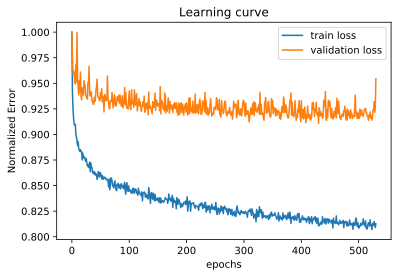

In [37]:
# Plotting the learning curve 
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.plot(history.history['loss']/np.max(history.history['loss']))
plt.plot(history.history['val_loss']/np.max(history.history['val_loss']))
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])


plt.title('Learning curve')
# plt.ylabel('Error/Accuracy')
plt.ylabel('Normalized Error')
plt.xlabel('epochs')
plt.legend(['train loss', 'validation loss'], loc='upper right')
# plt.savefig('/Figures/learning_curve_08Nov.png', bbox_inches='tight')

In [38]:
# Predict training and test data using the trained network
test_output_petro_norm = PetroModel.predict(X_test_petro)
train_output_petro_norm = PetroModel.predict(X_train_petro)

# Initialization
train_output_petro = np.zeros(train_output_petro_norm.shape)
test_output_petro = np.zeros(test_output_petro_norm.shape)
Y_train_petro = np.zeros(Y_train_petro_norm.shape)
Y_test_petro = np.zeros(Y_test_petro_norm.shape)

# Back transforming porosity to unnormalized values 
train_output_petro[:,0,:] = train_output_petro_norm[:,0,:]*(np.max(porosity) - np.min(porosity)) + np.min(porosity)
test_output_petro[:,0,:] = test_output_petro_norm[:,0,:]*(np.max(porosity) - np.min(porosity)) + np.min(porosity)

train_output_petro[:,1,:] = train_output_petro_norm[:,1,:]
test_output_petro[:,1,:] = test_output_petro_norm[:,1,:]

Y_train_petro[:,0,:] = Y_train_petro_norm[:,0,:]*(np.max(porosity) - np.min(porosity)) + np.min(porosity)
Y_test_petro[:,0,:] = Y_test_petro_norm[:,0,:]*(np.max(porosity) - np.min(porosity)) + np.min(porosity)

Y_train_petro[:,1,:] = Y_train_petro_norm[:,1,:]
Y_test_petro[:,1,:] = Y_test_petro_norm[:,1,:]

In [29]:
# RMSE with respect to mean 
rmse_train = np.sqrt(np.mean(((train_output_petro - Y_train_petro)**2).mean(axis=2), axis = 0))/np.mean(np.mean(Y_train_petro, axis = 0), axis=1)
rmse_test = np.sqrt(np.mean(((test_output_petro - Y_test_petro)**2).mean(axis=2), axis = 0))/np.mean(np.mean(Y_test_petro, axis = 0), axis=1)

print("Training error = ", rmse_train)
print("Test error = ", rmse_test)

Training error =  [0.17052618 0.30260018]
Test error =  [0.19341821 0.3788528 ]


(0, 1)

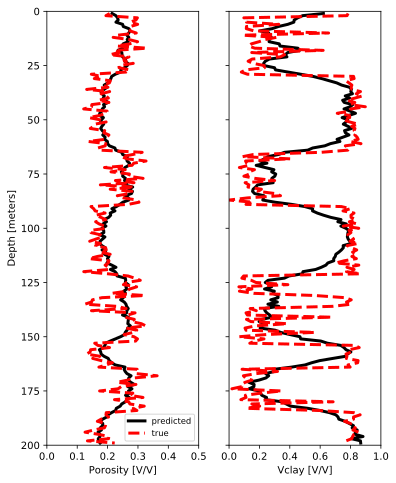

In [97]:
# Checking training data

sample_number = 25
f, axarr = plt.subplots(1, 2, sharey = True, figsize=(6,8))

axarr[0].plot(train_output_petro[sample_number, 0, :], depth, '-k', label='predicted', linewidth=3)
axarr[0].plot(Y_train_petro[sample_number, 0, :], depth, '--r', label='true', linewidth=3)
axarr[0].set_xlabel("Porosity [V/V]")
axarr[0].set_ylabel("Depth [meters]")
axarr[0].invert_yaxis()
axarr[0].set_xlim(0,0.5)
axarr[0].set_ylim(0,200)
axarr[0].legend(fontsize = 'small')

axarr[1].plot(train_output_petro[sample_number, 1, :], depth, '-k', linewidth=3)
axarr[1].plot(Y_train_petro[sample_number, 1, :], depth, '--r', linewidth=3)
axarr[1].set_xlabel("Vclay [V/V]")
# axarr[1].set_ylabel("Depth [meters]")
axarr[1].invert_yaxis()
axarr[1].set_xlim(0,1)

# axarr[2].plot(train_output_petro[sample_number, 2, :], depth, '-k')
# axarr[2].plot(Y_train_petro[sample_number, 2, :], depth, '--r')
# axarr[2].set_xlabel("Sw")
# axarr[2].set_ylabel("Depth")
# axarr[2].invert_yaxis()
# axarr[2].set_xlim(0,1)

# axarr[2].plot(train_output_petro_norm[sample_number, 0, :], depth, '-k')
# axarr[2].plot(Y_train_petro_norm[sample_number, 0, :], depth, '--r')
# axarr[2].set_xlabel("Norm_Poro")
# axarr[2].set_ylabel("Depth")
# axarr[2].invert_yaxis()
# axarr[2].set_xlim(0,1)

(0, 1)

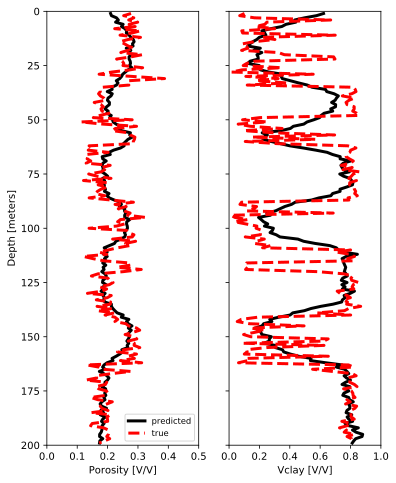

In [96]:
# Checking testing data

sample_number = 12
f, axarr = plt.subplots(1, 2, sharey = True, figsize=(6,8))

axarr[0].plot(test_output_petro[sample_number, 0, :], depth, '-k', label='predicted', linewidth=3)
axarr[0].plot(Y_test_petro[sample_number, 0, :], depth, '--r', label='true', linewidth=3)
axarr[0].set_xlabel("Porosity [V/V]")
axarr[0].set_ylabel("Depth [meters]")
axarr[0].invert_yaxis()
axarr[0].set_xlim(0,0.5)
axarr[0].set_ylim(0,200)
axarr[0].legend(fontsize = 'small')

axarr[1].plot(test_output_petro[sample_number, 1, :], depth, '-k', linewidth=3)
axarr[1].plot(Y_test_petro[sample_number, 1, :], depth, '--r', linewidth=3)
axarr[1].set_xlabel("Vclay [V/V]")
# axarr[1].set_ylabel("Depth")
axarr[1].invert_yaxis()
axarr[1].set_xlim(0,1)

# axarr[2].plot(test_output_petro[sample_number, 2, :], depth, '-k')
# axarr[2].plot(Y_test_petro[sample_number, 2, :], depth, '--r')
# axarr[2].set_xlabel("Sw")
# axarr[2].set_ylabel("Depth")
# axarr[2].invert_yaxis()
# axarr[2].set_xlim(0,1)

# axarr[2].plot(test_output_petro_norm[sample_number, 0, :], depth, '-k')
# axarr[2].plot(Y_test_petro_norm[sample_number, 0, :], depth, '--r')
# axarr[2].set_xlabel("Norm_Poro")
# axarr[2].set_ylabel("Depth")
# axarr[2].invert_yaxis()
# axarr[2].set_xlim(0,1)

In [53]:
# Correlation coefficient between true and predicted traces 

Porosity_corr_train = np.zeros(train_output_petro.shape[0])
Vclay_corr_train = np.zeros(train_output_petro.shape[0])
# Sw_corr_train = np.zeros(train_output_petro.shape[0])
for i in range(train_output_petro.shape[0]):
    Porosity_corr_train[i] = np.corrcoef(train_output_petro[i,0,:], Y_train_petro[i,0,:])[0,1]
    Vclay_corr_train[i] = np.corrcoef(train_output_petro[i,1,:], Y_train_petro[i,1,:])[0,1]
#     Sw_corr_train[i] = np.corrcoef(train_output_petro[i,2,:], Y_train_petro[i,2,:])[0,1]
    
Porosity_corr_test = np.zeros(test_output_petro.shape[0])
Vclay_corr_test = np.zeros(test_output_petro.shape[0])
Sw_corr_test = np.zeros(test_output_petro.shape[0])
for i in range(test_output_petro.shape[0]):
    Porosity_corr_test[i] = np.corrcoef(test_output_petro[i,0,:], Y_test_petro[i,0,:])[0,1]
    Vclay_corr_test[i] = np.corrcoef(test_output_petro[i,1,:], Y_test_petro[i,1,:])[0,1]
#     Sw_corr_test[i] = np.corrcoef(test_output_petro[i,2,:], Y_test_petro[i,2,:])[0,1]

    
# Average correlation coefficient
print("Average correlation in porosity for training data = ", np.mean(Porosity_corr_train))
print("Average correlation in Vclay for training data = ", np.mean(Vclay_corr_train))
# print("Average correlation in Sw for training data = ", np.mean(Sw_corr_train))

print("Average correlation in porosity for test data = ", np.mean(Porosity_corr_test))
print("Average correlation in Vclay for test data = ", np.mean(Vclay_corr_test))
# print("Average correlation in Sw for test data = ", np.mean(Sw_corr_test))


Average correlation in porosity for training data =  0.6918245671591681
Average correlation in Vclay for training data =  0.8030678810321689
Average correlation in porosity for test data =  0.6284633994819817
Average correlation in Vclay for test data =  0.7427623625755296


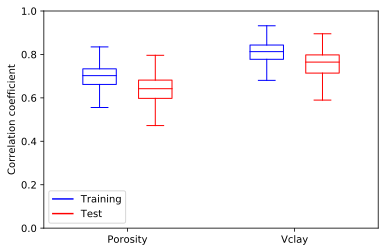

In [54]:
# Box plot of correlation coefficients 

from pylab import plot, show, savefig, xlim, figure, \
                hold, ylim, legend, boxplot, setp, axes

# function for setting the colors of the box plots pairs
def setBoxColors(bp):
    setp(bp['boxes'][0], color='blue')
    setp(bp['caps'][0], color='blue')
    setp(bp['caps'][1], color='blue')
    setp(bp['whiskers'][0], color='blue')
    setp(bp['whiskers'][1], color='blue')
#     setp(bp['fliers'][0], color='blue')
#     setp(bp['fliers'][1], color='blue')
    setp(bp['medians'][0], color='blue')

    setp(bp['boxes'][1], color='red')
    setp(bp['caps'][2], color='red')
    setp(bp['caps'][3], color='red')
    setp(bp['whiskers'][2], color='red')
    setp(bp['whiskers'][3], color='red')
#     setp(bp['fliers'][2], color='red')
#     setp(bp['fliers'][3], color='red')
    setp(bp['medians'][1], color='red')

# Some fake data to plot
A= [Porosity_corr_train, Porosity_corr_test]
B = [Vclay_corr_train, Vclay_corr_test]
# C = [Sw_corr_train, Sw_corr_test]

fig = figure()
ax = axes()

# first boxplot pair
bp = boxplot(A, positions = [1, 2], widths = 0.6, showfliers=False)
setBoxColors(bp)

# second boxplot pair
bp = boxplot(B, positions = [4, 5], widths = 0.6, showfliers=False)
setBoxColors(bp)

# thrid boxplot pair
# bp = boxplot(C, positions = [7, 8], widths = 0.6, showfliers=False)
# setBoxColors(bp)

# set axes limits and labels
# xlim(0,9)
xlim(0,6)
ylim(0,1)
# ax.set_xticklabels(['Porosity', 'Vclay', 'Sw'])
ax.set_xticklabels(['Porosity', 'Vclay'])
# ax.set_xticks([1.5, 4.5, 7.5])
ax.set_xticks([1.5, 4.5])
plt.ylabel('Correlation coefficient')

# draw temporary red and blue lines and use them to create a legend
hB, = plot([1,1],'b-')
hR, = plot([1,1],'r-')
legend((hB, hR),('Training', 'Test'), loc='lower left')
hB.set_visible(False)
hR.set_visible(False)

In [ ]:
# Histogram plot for true vs predicted values
for i in np.arange(0,train_output_petro.shape[0],100):
    plt.hist(Y_train_petro[i,0,:], histtype='step', color='black')
    plt.hist(train_output_petro[i,0,:], histtype='step', color='red')
    plt.xlabel('Porosity')
    plt.ylabel('Frequency')
    plt.title('Training examples')



In [ ]:
# Histogram plot for true vs predicted values
for i in np.arange(0,train_output_petro.shape[0],100):
    plt.hist(Y_train_petro[i,1,:], histtype='step', color='black')
    plt.hist(train_output_petro[i,1,:], histtype='step', color='red')
    plt.xlabel('Vclay')
    plt.ylabel('Frequency')
    plt.title('Training examples')

In [ ]:
# Histogram plot for true vs predicted values
for i in np.arange(0,train_output_petro.shape[0],100):
    plt.hist(Y_train_petro[i,2,:], histtype='step', color='black')
    plt.hist(train_output_petro[i,2,:], histtype='step', color='red')
    plt.xlabel('Sw')
    plt.ylabel('Frequency')
    plt.title('Training examples')

In [ ]:
for i in range(test_output_petro.shape[0]):
    plt.hist(Y_test_petro[i,0,:], histtype='step', color='black')
    plt.hist(test_output_petro[i,0,:], histtype='step', color='red')
    plt.xlabel('Porosity')
    plt.ylabel('Frequency')
    plt.title('Test examples')

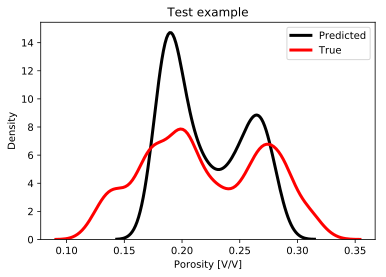

In [58]:
# Density estimate for true vs predicted (test example) Porosity

import seaborn as sns

sample_number = 12
sns.kdeplot(test_output_petro[sample_number,0,:],  
             color='black', label='Predicted', linewidth=3,
            bw=0.01,
             clip=(np.min(test_output_petro[sample_number,0,:]), np.max(test_output_petro[sample_number,0,:])))
sns.kdeplot(Y_test_petro[sample_number,0,:],  
             color='red', label='True', linewidth=3,
            bw=0.01,
             clip=(np.min(Y_test_petro[sample_number,0,:]), np.max(Y_test_petro[sample_number,0,:])))
plt.xlabel('Porosity [V/V]')
plt.ylabel('Density')
plt.title('Test example')
plt.legend()

(-0.1, 1.1)

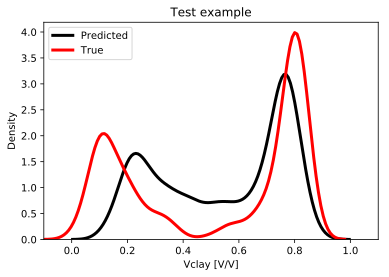

In [60]:
# Density estimate for true vs predicted (test example) Vclay

sample_number = 12

sns.kdeplot(test_output_petro[sample_number,1,:],  
             color='black', label='Predicted', linewidth=3,
             bw=0.04,
           clip=(np.min(test_output_petro[sample_number,1,:]), np.max(test_output_petro[sample_number,1,:])))
sns.kdeplot(Y_test_petro[sample_number,1,:],  
             color='red', label='True', linewidth=3,
            bw=0.04,
             clip=(np.min(Y_test_petro[sample_number,1,:]), np.max(Y_test_petro[sample_number,1,:])))
plt.xlabel('Vclay [V/V]')
plt.ylabel('Density')
plt.title('Test example')
plt.legend()
plt.xlim(-0.1,1.1)

In [ ]:
# Density estimate for true vs predicted (test example) Water saturation 

sample_number = 12

sns.kdeplot(test_output_petro[sample_number,2,:],  
             color='red', label='Predicted', linewidth=3,
             bw=0.04,
           clip=(np.min(test_output_petro[sample_number,2,:]), np.max(test_output_petro[sample_number,2,:])))
sns.kdeplot(Y_test_petro[sample_number,2,:],  
             color='black', label='True', linewidth=3,
            bw=0.04,
             clip=(np.min(Y_test_petro[sample_number,2,:]), np.max(Y_test_petro[sample_number,2,:])))
plt.xlabel('Sw')
plt.ylabel('Density')
plt.title('Test example')
plt.legend()
plt.xlim(-0.1,1.1)

In [ ]:
for i in range(test_output_petro.shape[0]):
    plt.hist(Y_test_petro[i,1,:], histtype='step', color='black')
    plt.hist(test_output_petro[i,1,:], histtype='step', color='red')
    plt.xlabel('Vclay')
    plt.ylabel('Frequency')
    plt.title('Test examples')

In [ ]:
for i in range(test_output_petro.shape[0]):
    plt.hist(Y_test_petro[i,2,:], histtype='step', color='black')
    plt.hist(test_output_petro[i,2,:], histtype='step', color='red')
    plt.xlabel('Sw')
    plt.ylabel('Frequency')
    plt.title('Test examples')

In [ ]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 25
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_train_petro[sample_number,0,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black")
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Training dataset (Porosity)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, train_output_petro[sample_number,0,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red")
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

In [ ]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 25
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_train_petro[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black")
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Training dataset (Vclay)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, train_output_petro[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red")
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

In [ ]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 25
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_train_petro[sample_number,2,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black")
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Training dataset (Sw)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, train_output_petro[sample_number,2,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red")
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

({'var': 0.0012858600288278828,
  'len_scale': 21.653115527199805,
  'nugget': 4.6859511462637324e-30},
 array([[ 1.65225022e-08, -1.42258073e-04, -1.51855140e-08],
        [-1.42258073e-04,  7.43312262e+00,  1.91844479e-04],
        [-1.51855140e-08,  1.91844479e-04,  1.56151202e-08]]))

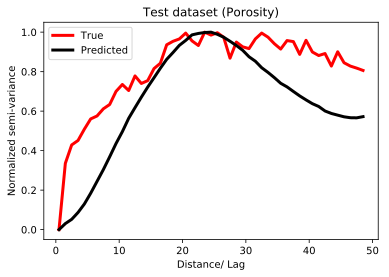

In [95]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 12
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_test_petro[sample_number,0,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red",linewidth=3)
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Test dataset (Porosity)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, test_output_petro[sample_number,0,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black",linewidth=3)
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

({'var': 0.05740237589704929,
  'len_scale': 22.067884867093987,
  'nugget': 1.4873531634828614e-35},
 array([[ 3.51739253e-05, -6.83927819e-03, -3.22430058e-05],
        [-6.83927819e-03,  8.28904383e+00,  9.32959435e-03],
        [-3.22430058e-05,  9.32959435e-03,  3.31917692e-05]]))

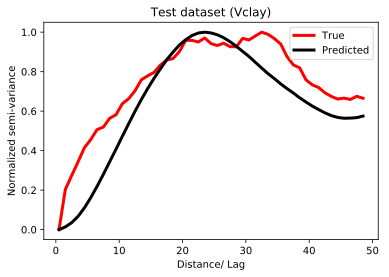

In [94]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 12
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_test_petro[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red",linewidth=3)
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Test dataset (Vclay)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, test_output_petro[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black",linewidth=3)
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

In [ ]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 12
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_test_petro[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black")
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Test dataset (Sw)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, test_output_petro[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red")
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

In [ ]:
# Spectral coherence between true and predicted 

sample_number = 25
plt.cohere(Y_train_petro[sample_number,0,:], train_output_petro[sample_number,0,:], NFFT=16, Fs=1, color="blue")
plt.cohere(Y_train_petro[sample_number,1,:], train_output_petro[sample_number,1,:], NFFT=16, Fs=1, color="red") 
# plt.cohere(Y_train_petro[sample_number,2,:], train_output_petro[sample_number,2,:], NFFT=16, Fs=1, color="black")


# plt.gca().legend(('Porosity','Vclay', 'Sw'))
plt.gca().legend(('Porosity','Vclay'))
plt.xlabel('Wavenumber')
plt.ylabel('Coherence')
plt.title('Training example')
plt.grid(b=False)

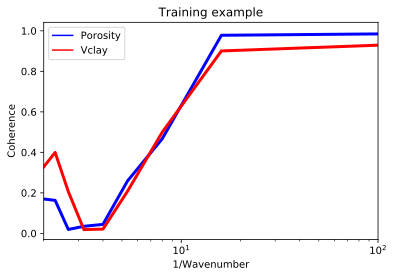

In [93]:
# Spectral coherence between true and predicted (training data)

sample_number = 25
Cxy_poro, wavenumber_poro = plt.cohere(Y_train_petro[sample_number,0,:], train_output_petro[sample_number,0,:], NFFT=16, Fs=1, color="blue")
Cxy_vclay, wavenumber_vclay = plt.cohere(Y_train_petro[sample_number,1,:], train_output_petro[sample_number,1,:], NFFT=16, Fs=1, color="red") 
# Cxy_sw, wavenumber_sw = plt.cohere(Y_test_petro[sample_number,2,:], test_output_petro[sample_number,2,:], NFFT=16, Fs=1, color="black")

# Adding epsilon to the first wavenumber value
wavenumber_poro[0] = wavenumber_poro[0] + 0.001
wavenumber_vclay[0] = wavenumber_vclay[0] + 0.001
# wavenumber_sw[0] = wavenumber_sw[0] + 0.001

plt.plot(1/wavenumber_poro, Cxy_poro, color="blue", linewidth=3)
plt.plot(1/wavenumber_vclay, Cxy_vclay, color="red", linewidth=3)
# plt.plot(1/wavenumber_sw, Cxy_sw, color="black")

plt.xlim(100,2)
plt.gca().invert_xaxis()
plt.xscale("log")

# plt.gca().legend(('Porosity','Vclay', 'Sw'))
plt.gca().legend(('Porosity','Vclay'))
plt.xlabel('1/Wavenumber')
plt.ylabel('Coherence')
plt.title('Training example')
plt.grid(b=False)

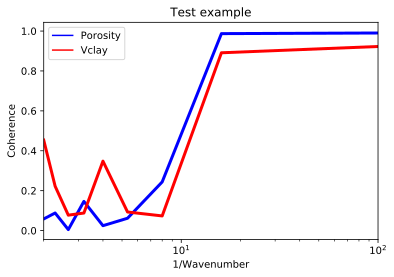

In [92]:
# Spectral coherence between true and predicted (test data)

sample_number = 12
Cxy_poro, wavenumber_poro = plt.cohere(Y_test_petro[sample_number,0,:], test_output_petro[sample_number,0,:], NFFT=16, Fs=1, color="blue")
Cxy_vclay, wavenumber_vclay = plt.cohere(Y_test_petro[sample_number,1,:], test_output_petro[sample_number,1,:], NFFT=16, Fs=1, color="red") 
# Cxy_sw, wavenumber_sw = plt.cohere(Y_test_petro[sample_number,2,:], test_output_petro[sample_number,2,:], NFFT=16, Fs=1, color="black")

# Adding epsilon to the first wavenumber value
wavenumber_poro[0] = wavenumber_poro[0] + 0.001
wavenumber_vclay[0] = wavenumber_vclay[0] + 0.001
# wavenumber_sw[0] = wavenumber_sw[0] + 0.001

plt.plot(1/wavenumber_poro, Cxy_poro, color="blue", linewidth=3)
plt.plot(1/wavenumber_vclay, Cxy_vclay, color="red", linewidth=3)
# plt.plot(1/wavenumber_sw, Cxy_sw, color="black")

plt.xlim(100,2)
plt.gca().invert_xaxis()
plt.xscale("log")

# plt.gca().legend(('Porosity','Vclay', 'Sw'))
plt.gca().legend(('Porosity','Vclay'))
plt.xlabel('1/Wavenumber')
plt.ylabel('Coherence')
plt.title('Test example')
plt.grid(b=False)

(0, 1)

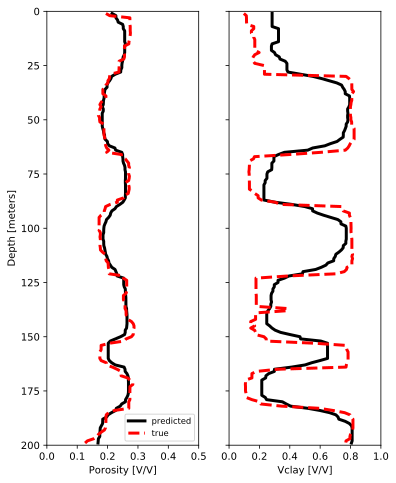

In [91]:
import scipy.signal as sp


# Checking training data (smoothed)

sample_number = 25
f, axarr = plt.subplots(1, 2, sharey = True, figsize=(6,8))

ker_width = 15

axarr[0].plot(sp.medfilt(train_output_petro[sample_number, 0, :],ker_width), depth, '-k', label='predicted', linewidth=3)
axarr[0].plot(sp.medfilt(Y_train_petro[sample_number, 0, :], ker_width), depth, '--r',  label='true', linewidth=3)
axarr[0].set_xlabel("Porosity [V/V]")
axarr[0].set_ylabel("Depth [meters]")
axarr[0].invert_yaxis()
axarr[0].set_xlim(0,0.5)
axarr[0].set_ylim(0,200)
axarr[0].legend(fontsize='small')

axarr[1].plot(sp.medfilt(train_output_petro[sample_number, 1, :], ker_width), depth, '-k', linewidth=3)
axarr[1].plot(sp.medfilt(Y_train_petro[sample_number, 1, :],ker_width), depth, '--r', linewidth=3)
axarr[1].set_xlabel("Vclay [V/V]")
# axarr[1].set_ylabel("Depth")
axarr[1].invert_yaxis()
axarr[1].set_xlim(0,1)

In [68]:
por_corr_coeff_smooth_train = np.corrcoef(sp.medfilt(train_output_petro[sample_number, 0, :],ker_width),
                                                     sp.medfilt(Y_train_petro[sample_number, 0, :], ker_width))
                                          
vclay_corr_coeff_smooth_train = np.corrcoef(sp.medfilt(train_output_petro[sample_number, 1, :],ker_width),
                                                     sp.medfilt(Y_train_petro[sample_number, 1, :], ker_width))

print("Correlation coefficient between smoothed true and predicted porosity for training example = ", 
     '%.3f'%(por_corr_coeff_smooth_train[0,1]))
print("Correlation coefficient between smoothed true and predicted vclay for training example = ", 
     '%.3f'%(vclay_corr_coeff_smooth_train[0,1]))

Correlation coefficient between smoothed true and predicted porosity for training example =  0.921
Correlation coefficient between smoothed true and predicted vclay for training example =  0.942


(0, 1)

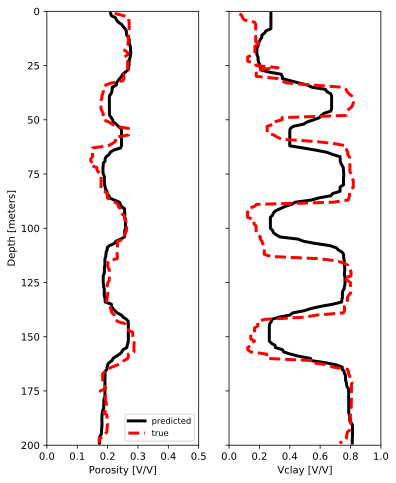

In [90]:
# Checking testing data (smoothed)

sample_number = 12
f, axarr = plt.subplots(1, 2, sharey = True, figsize=(6,8))

ker_width = 15

axarr[0].plot(sp.medfilt(test_output_petro[sample_number, 0, :],ker_width), depth, '-k', label='predicted', linewidth=3)
axarr[0].plot(sp.medfilt(Y_test_petro[sample_number, 0, :], ker_width), depth, '--r',  label='true', linewidth=3)
axarr[0].set_xlabel("Porosity [V/V]")
axarr[0].set_ylabel("Depth [meters]")
axarr[0].invert_yaxis()
axarr[0].set_xlim(0,0.5)
axarr[0].set_ylim(0,200)
axarr[0].legend(fontsize='small')

axarr[1].plot(sp.medfilt(test_output_petro[sample_number, 1, :],ker_width), depth, '-k', linewidth=3)
axarr[1].plot(sp.medfilt(Y_test_petro[sample_number, 1, :],ker_width), depth, '--r', linewidth=3)
axarr[1].set_xlabel("Vclay [V/V]")
# axarr[1].set_ylabel("Depth")
axarr[1].invert_yaxis()
axarr[1].set_xlim(0,1)

In [70]:
por_corr_coeff_smooth_test = np.corrcoef(sp.medfilt(test_output_petro[sample_number, 0, :],ker_width),
                                                     sp.medfilt(Y_test_petro[sample_number, 0, :], ker_width))
                                          
vclay_corr_coeff_smooth_test = np.corrcoef(sp.medfilt(test_output_petro[sample_number, 1, :],ker_width),
                                                     sp.medfilt(Y_test_petro[sample_number, 1, :], ker_width))

print("Correlation coefficient between smoothed true and predicted porosity for test example = ", 
     '%.3f'%(por_corr_coeff_smooth_test[0,1]))
print("Correlation coefficient between smoothed true and predicted vclay for test example = ", 
     '%.3f'%(vclay_corr_coeff_smooth_test[0,1]))

Correlation coefficient between smoothed true and predicted porosity for test example =  0.813
Correlation coefficient between smoothed true and predicted vclay for test example =  0.875


In [71]:
# Uncertainty estimation using dropout
class KerasDropoutPrediction(object):
    def __init__(self,model):
        self.f = K.function(
                [model.layers[0].input, 
                 K.learning_phase()],
                [model.layers[-1].output])
    def predict(self,x, n_iter=10):
        result = []
        for _ in range(n_iter):
            result.append(self.f([x , 1]))
#         result = np.array(result).reshape(n_iter,len(x)).T
        return result

In [72]:
# Uncertainty estimation for training data 

kdp = KerasDropoutPrediction(PetroModel)
nsim = 1000
Y_train_petro_uncertainty = np.array(kdp.predict(X_train_petro,nsim))
Y_train_petro_uncertainty_reshaped = np.reshape(
    Y_train_petro_uncertainty, (nsim, Y_train_petro.shape[0], Y_train_petro.shape[1], Y_train_petro.shape[2]))


Y_train_petro_uncertainty_reshaped_p50_norm = np.percentile(Y_train_petro_uncertainty_reshaped, 50, axis=0)
Y_train_petro_uncertainty_reshaped_p50 = Y_train_petro_uncertainty_reshaped_p50_norm
Y_train_petro_uncertainty_reshaped_p50[:,0,:] = Y_train_petro_uncertainty_reshaped_p50_norm[:,0,:]*(
    np.max(porosity) - np.min(porosity)) + np.min(porosity)

Y_train_petro_uncertainty_reshaped_p5_norm = np.percentile(Y_train_petro_uncertainty_reshaped, 5, axis=0)
Y_train_petro_uncertainty_reshaped_p5 = Y_train_petro_uncertainty_reshaped_p5_norm
Y_train_petro_uncertainty_reshaped_p5[:,0,:] = Y_train_petro_uncertainty_reshaped_p5_norm[:,0,:]*(
    np.max(porosity) - np.min(porosity)) + np.min(porosity)

Y_train_petro_uncertainty_reshaped_p95_norm = np.percentile(Y_train_petro_uncertainty_reshaped, 95, axis=0)
Y_train_petro_uncertainty_reshaped_p95 = Y_train_petro_uncertainty_reshaped_p95_norm
Y_train_petro_uncertainty_reshaped_p95[:,0,:] = Y_train_petro_uncertainty_reshaped_p95_norm[:,0,:]*(
    np.max(porosity) - np.min(porosity)) + np.min(porosity)


(0, 1)

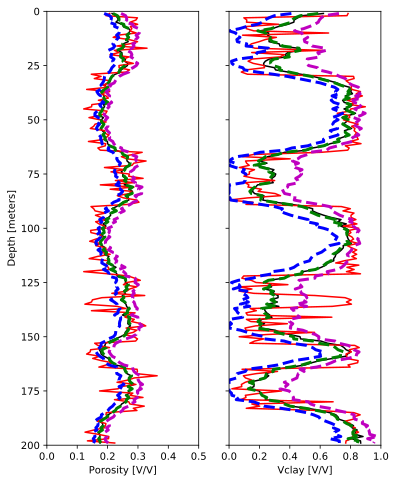

In [87]:
# Checking training data

sample_number = 25
f, axarr = plt.subplots(1, 2, sharey = True, figsize = (6,8))

axarr[0].plot(train_output_petro[sample_number, 0, :], depth, '-k', label='predicted')
axarr[0].plot(Y_train_petro[sample_number, 0, :], depth, '-r', label='true')
axarr[0].plot(Y_train_petro_uncertainty_reshaped_p50[sample_number, 0, :], depth, '--g', label='p50', linewidth = 3)
axarr[0].plot(Y_train_petro_uncertainty_reshaped_p5[sample_number, 0, :], depth, '--b', label='p5', linewidth = 3)
axarr[0].plot(Y_train_petro_uncertainty_reshaped_p95[sample_number, 0, :], depth, '--m', label='p95', linewidth = 3)
axarr[0].set_xlabel("Porosity [V/V]")
axarr[0].set_ylabel("Depth [meters]")
axarr[0].invert_yaxis()
axarr[0].set_xlim(0,0.5)
axarr[0].set_ylim(0,200)
# axarr[0].legend(fontsize = 'small')

axarr[1].plot(train_output_petro[sample_number, 1, :], depth, '-k')
axarr[1].plot(Y_train_petro[sample_number, 1, :], depth, '-r')
axarr[1].plot(Y_train_petro_uncertainty_reshaped_p50[sample_number, 1, :], depth, '--g', linewidth = 3)
axarr[1].plot(Y_train_petro_uncertainty_reshaped_p5[sample_number, 1, :], depth, '--b', linewidth = 3)
axarr[1].plot(Y_train_petro_uncertainty_reshaped_p95[sample_number, 1, :], depth, '--m', linewidth = 3)
axarr[1].set_xlabel("Vclay [V/V]")
# axarr[1].set_ylabel("Depth [meters]")
axarr[1].invert_yaxis()
axarr[1].set_xlim(0,1)


In [76]:
# Uncertainty estimation for test data 

kdp = KerasDropoutPrediction(PetroModel)
nsim = 1000
Y_test_petro_uncertainty = np.array(kdp.predict(X_test_petro,nsim))
Y_test_petro_uncertainty_reshaped = np.reshape(
    Y_test_petro_uncertainty, (nsim, Y_test_petro.shape[0], Y_test_petro.shape[1], Y_test_petro.shape[2]))


Y_test_petro_uncertainty_reshaped_p50_norm = np.percentile(Y_test_petro_uncertainty_reshaped, 50, axis=0)
Y_test_petro_uncertainty_reshaped_p50 = Y_test_petro_uncertainty_reshaped_p50_norm
Y_test_petro_uncertainty_reshaped_p50[:,0,:] = Y_test_petro_uncertainty_reshaped_p50_norm[:,0,:]*(
    np.max(porosity) - np.min(porosity)) + np.min(porosity)

Y_test_petro_uncertainty_reshaped_p5_norm = np.percentile(Y_test_petro_uncertainty_reshaped, 5, axis=0)
Y_test_petro_uncertainty_reshaped_p5 = Y_test_petro_uncertainty_reshaped_p5_norm
Y_test_petro_uncertainty_reshaped_p5[:,0,:] = Y_test_petro_uncertainty_reshaped_p5_norm[:,0,:]*(
    np.max(porosity) - np.min(porosity)) + np.min(porosity)

Y_test_petro_uncertainty_reshaped_p95_norm = np.percentile(Y_test_petro_uncertainty_reshaped, 95, axis=0)
Y_test_petro_uncertainty_reshaped_p95 = Y_test_petro_uncertainty_reshaped_p95_norm
Y_test_petro_uncertainty_reshaped_p95[:,0,:] = Y_test_petro_uncertainty_reshaped_p95_norm[:,0,:]*(
    np.max(porosity) - np.min(porosity)) + np.min(porosity)

(0, 1)

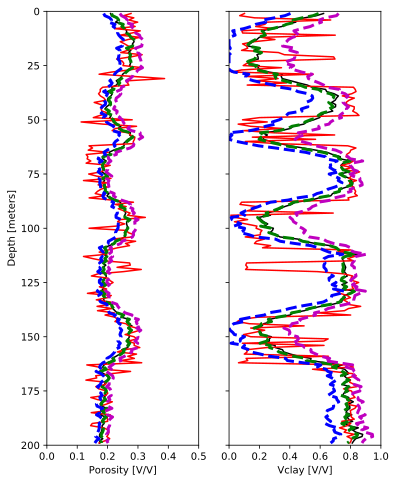

In [88]:
# Checking testing data

sample_number = 12
f, axarr = plt.subplots(1, 2, sharey = True, figsize = (6,8))

axarr[0].plot(test_output_petro[sample_number, 0, :], depth, '-k', label='predicted')
axarr[0].plot(Y_test_petro[sample_number, 0, :], depth, '-r', label='true')
axarr[0].plot(Y_test_petro_uncertainty_reshaped_p50[sample_number, 0, :], depth, '--g', label='p50', linewidth = 3)
axarr[0].plot(Y_test_petro_uncertainty_reshaped_p5[sample_number, 0, :], depth, '--b', label='p5', linewidth = 3)
axarr[0].plot(Y_test_petro_uncertainty_reshaped_p95[sample_number, 0, :], depth, '--m', label='p95', linewidth = 3)
axarr[0].set_xlabel("Porosity [V/V]")
axarr[0].set_ylabel("Depth [meters]")
axarr[0].invert_yaxis()
axarr[0].set_xlim(0,0.5)
axarr[0].set_ylim(0,200)
# axarr[0].legend(fontsize = 'small')

axarr[1].plot(test_output_petro[sample_number, 1, :], depth, '-k')
axarr[1].plot(Y_test_petro[sample_number, 1, :], depth, '-r')
axarr[1].plot(Y_test_petro_uncertainty_reshaped_p50[sample_number, 1, :], depth, '--g', linewidth = 3)
axarr[1].plot(Y_test_petro_uncertainty_reshaped_p5[sample_number, 1, :], depth, '--b', linewidth = 3)
axarr[1].plot(Y_test_petro_uncertainty_reshaped_p95[sample_number, 1, :], depth, '--m', linewidth = 3)
axarr[1].set_xlabel("Vclay [V/V]")
# axarr[1].set_ylabel("Depth")
axarr[1].invert_yaxis()
axarr[1].set_xlim(0,1)

